# Data Preprocessing

### 1. Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (ResNet50, DenseNet121, EfficientNetB0, InceptionV3, MobileNetV2)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

### 2. Remove Duplicate Images

In [8]:
import os
import hashlib
import shutil
from PIL import Image

def hash_image(image_path):
    # Generate a hash for an image file.
    with Image.open(image_path) as img:
        return hashlib.md5(img.tobytes()).hexdigest()

def detect_duplicates_and_copy_uniques(src_dir, dst_dir):
    # Detect duplicates from src_dir and copy unique images to dst_dir.
    hashes = {}
    duplicated_detected = 0
    total = 0

    for class_name in os.listdir(src_dir):
        src_class_path = os.path.join(src_dir, class_name)
        dst_class_path = os.path.join(dst_dir, class_name)

        if not os.path.isdir(src_class_path):
            continue

        os.makedirs(dst_class_path, exist_ok=True)

        for filename in os.listdir(src_class_path):
            file_path = os.path.join(src_class_path, filename)
            try:
                img_hash = hash_image(file_path)
                total += 1
                if img_hash not in hashes:
                    hashes[img_hash] = file_path
                    shutil.copy(file_path, os.path.join(dst_class_path, filename))
                else:
                    duplicated_detected += 1
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    print(f"Processed: {src_dir} -> Deteced {duplicated_detected} / {total} duplicates.")


# Define paths
original_dataset_path = '/kaggle/input/teeth-disease-dataset/Teeth_Dataset'
cleaned_dataset_path = '/kaggle/working/Cleaned Teeth Dataset'

splits = {
    'Training': 'Cleaned Training',
    'Validation': 'Cleaned Validation',
    'Testing': 'Cleaned Testing'
}

# Create required directories for the cleaned dataset
if os.path.exists(cleaned_dataset_path):
    shutil.rmtree(cleaned_dataset_path)
os.makedirs(cleaned_dataset_path)
for cleaned_split in splits.values():
    os.makedirs(os.path.join(cleaned_dataset_path, cleaned_split))

for split, cleaned_split in splits.items():
    src = os.path.join(original_dataset_path, split)
    dst = os.path.join(cleaned_dataset_path, cleaned_split)
    detect_duplicates_and_copy_uniques(src, dst)

Processed: /kaggle/input/teeth-disease-dataset/Teeth_Dataset/Training -> Deteced 12 / 3087 duplicates.
Processed: /kaggle/input/teeth-disease-dataset/Teeth_Dataset/Validation -> Deteced 0 / 1028 duplicates.
Processed: /kaggle/input/teeth-disease-dataset/Teeth_Dataset/Testing -> Deteced 2 / 1028 duplicates.


### 3. Data Augmentation and Normalization
Training data is normalized and augmented, but validation data and testing data are normalized only.

In [9]:
# Paths of the clean data splits (after detecting duplicate images)
cleaned_paths = {
    'Training': '/kaggle/working/Cleaned Teeth Dataset/Cleaned Training',
    'Validation': '/kaggle/working/Cleaned Teeth Dataset/Cleaned Validation',
    'Testing': '/kaggle/working/Cleaned Teeth Dataset/Cleaned Testing'
}

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(cleaned_paths['Training'],
                                           target_size=IMAGE_SIZE,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           class_mode='categorical')

val_data = val_test_gen.flow_from_directory(cleaned_paths['Validation'],
                                            target_size=IMAGE_SIZE,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            class_mode='categorical')

test_data = val_test_gen.flow_from_directory(cleaned_paths['Testing'],
                                             target_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             class_mode='categorical',)


Found 3075 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1026 images belonging to 7 classes.


### 4. Plot Samples of Training Data (After Augmentation)

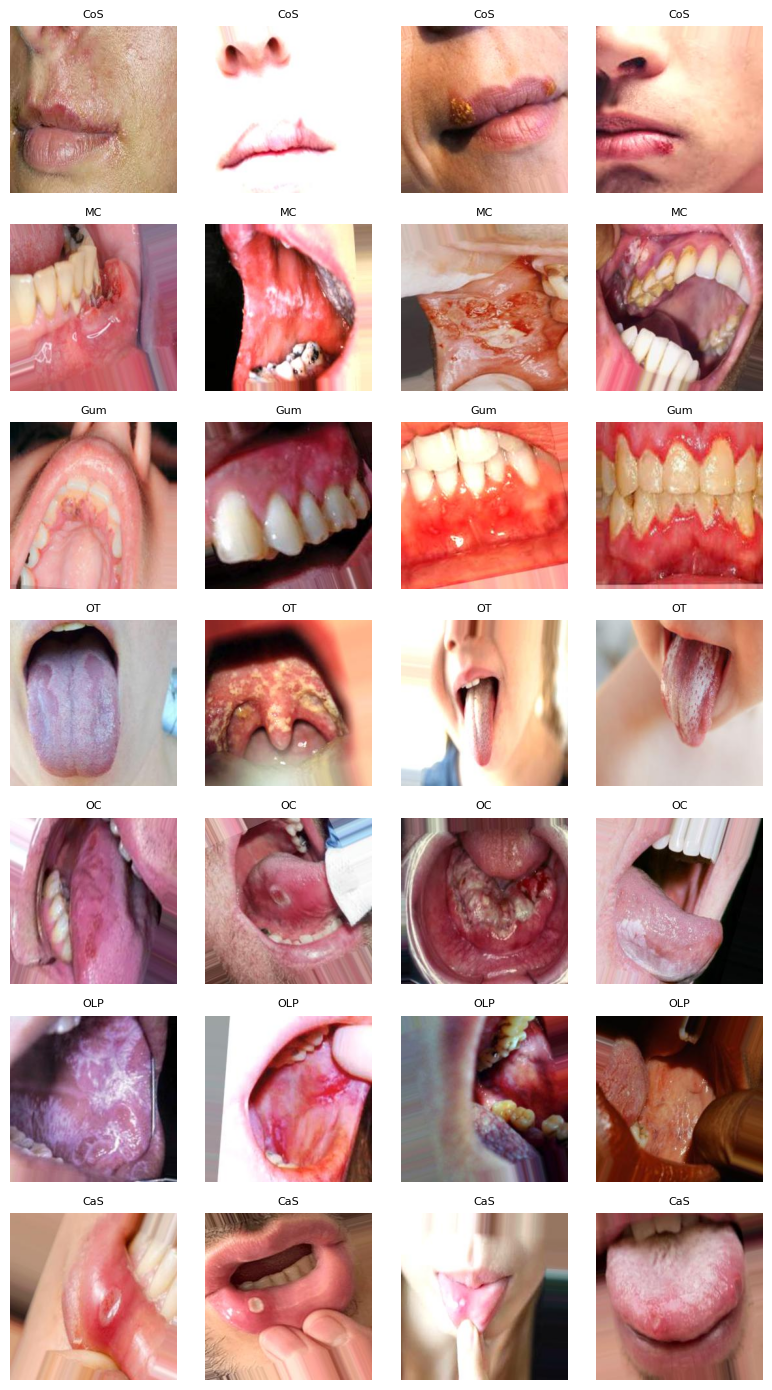

In [10]:
import random

def plot_samples(split_dir, class_names, samples_per_class=4):
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(cleaned_paths['Training'], class_name)
        images = os.listdir(class_path)
        images_selected = random.sample(images, min(samples_per_class, len(images)))

        for j, img_name in enumerate(images_selected):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                plt.subplot(len(class_names), samples_per_class, i * samples_per_class + j + 1)
                plt.imshow(img)
                plt.title(class_name, fontsize=8)
                plt.axis('off')
            except:
                continue
    plt.tight_layout()
    plt.show()

# Plot samples from the training set (after augmentation)
plot_samples(cleaned_paths['Training'], os.listdir(cleaned_paths['Training']))

# Modeling

### 1. Build All Models (Pretrained and Fine-Tuned)

In [11]:
# Function builds the models
def build_model(base_model_fn, fine_tune=False, unfreeze_layers=50):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    if fine_tune:
        for layer in base_model.layers[:-unfreeze_layers]:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True
    else:
        base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(7, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# After searching, I selected these 5 architectures to compare their performances
# ResNet50:       light, fast, and robust
# DenseNet121:    very good for small datasets
# EfficientNetB0: very high accuracy and compact
# InceptionV3:    good for complex features
# MobileNetV2:    lightweight
models_info = {
    "ResNet50": ResNet50,
    "DenseNet121": DenseNet121,
    "EfficientNetB0": EfficientNetB0,
    "InceptionV3": InceptionV3,
    "MobileNetV2": MobileNetV2
}

frozen_models = {}
fine_tuned_models = {}

# I create two versions of every architecture, pretrained and fine-tuned.
# So, we have 10 models total (5 pretrained, 5 fine-tuned)
for name, fn in models_info.items():
    print(f"Building {name} (frozen)...")
    frozen_models[name] = build_model(fn, fine_tune=False)

    print(f"Building {name} (fine-tuned)...")
    fine_tuned_models[name] = build_model(fn, fine_tune=True, unfreeze_layers=50)


Building ResNet50 (frozen)...
Building ResNet50 (fine-tuned)...
Building DenseNet121 (frozen)...
Building DenseNet121 (fine-tuned)...
Building EfficientNetB0 (frozen)...
Building EfficientNetB0 (fine-tuned)...
Building InceptionV3 (frozen)...
Building InceptionV3 (fine-tuned)...
Building MobileNetV2 (frozen)...
Building MobileNetV2 (fine-tuned)...


### 2. Train All Models

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1)

frozen_checkpoint = ModelCheckpoint(
    "best_frozen_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1)

fine_tune_checkpoint = ModelCheckpoint(
    filepath="best_finetuned_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1)

EPOCHS = 15

history_frozen = {}
history_tuned = {}

# Training of frozen(pretrained) models
for name, model in frozen_models.items():
    print(f"Training frozen {name}...")
    history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stop, frozen_checkpoint])
    history_frozen[name] = history

# Training of fine-tuned models
for name, model in fine_tuned_models.items():
    print(f"Training fine-tuned {name}...")
    history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stop, fine_tune_checkpoint])
    history_tuned[name] = history

Training frozen ResNet50...
Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.1504 - loss: 2.1302
Epoch 1: val_accuracy improved from -inf to 0.17510, saving model to best_frozen_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 441ms/step - accuracy: 0.1505 - loss: 2.1290 - val_accuracy: 0.1751 - val_loss: 1.9244
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.1629 - loss: 1.9276
Epoch 2: val_accuracy improved from 0.17510 to 0.19163, saving model to best_frozen_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 337ms/step - accuracy: 0.1629 - loss: 1.9276 - val_accuracy: 0.1916 - val_loss: 1.9174
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.1751 - loss: 1.9199
Epoch 3: val_accuracy improved from 0.19163 to 0.19844, saving model to best_frozen_model.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 333ms/step - accuracy: 0.1753 - loss: 1.9198 - val_accuracy: 0.1984 - val_loss: 1.9072
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.1893 - loss: 1.910

E0000 00:00:1752258406.976104  183535 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752258407.185646  183535 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752258407.507397  183535 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752258407.717201  183535 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


52/97 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.1631 - loss: 2.0476

E0000 00:00:1752258437.124207  183532 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752258437.332191  183532 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.1601 - loss: 2.0322
Epoch 1: val_accuracy did not improve from 0.99125
97/97 ━━━━━━━━━━━━━━━━━━━━ 91s 560ms/step - accuracy: 0.1601 - loss: 2.0320 - val_accuracy: 0.1556 - val_loss: 2.1418
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1704 - loss: 1.9545
Epoch 2: val_accuracy did not improve from 0.99125
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - accuracy: 0.1703 - loss: 1.9545 - val_accuracy: 0.1751 - val_loss: 1.9408
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.1576 - loss: 1.9482
Epoch 3: val_accuracy did not improve from 0.99125
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 0.1576 - loss: 1.9481 - val_accuracy: 0.1751 - val_loss: 1.9319
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.1509 - loss: 1.9402
Epoch 4: val_accuracy did not improve from 0.99125
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.1509 - loss: 1.9402 - val_accuracy: 0.1751 - val_loss

E0000 00:00:1752259202.017087  183534 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752259202.216562  183534 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5551 - loss: 1.2519
Epoch 1: val_accuracy did not improve from 0.99708
97/97 ━━━━━━━━━━━━━━━━━━━━ 68s 443ms/step - accuracy: 0.5565 - loss: 1.2481 - val_accuracy: 0.1809 - val_loss: 13.5159
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8755 - loss: 0.4205
Epoch 2: val_accuracy did not improve from 0.99708
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.8755 - loss: 0.4205 - val_accuracy: 0.2626 - val_loss: 20.1747
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8825 - loss: 0.4232
Epoch 3: val_accuracy did not improve from 0.99708
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step - accuracy: 0.8824 - loss: 0.4234 - val_accuracy: 0.2656 - val_loss: 20.9630
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9272 - loss: 0.2564
Epoch 4: val_accuracy did not improve from 0.99708
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.9272 - loss: 0.2565 - val_accuracy: 0.2286 - val_l

# Evaluation

### 1. Evaluate and Compare

In [18]:
frozen_accuracies = {}
fine_tuned_accuracies = {}

# Evaluation of frozen(pretrained) models
print("Evaluating Frozen Models:")
for name, model in frozen_models.items():
    eval = model.evaluate(test_data)
    frozen_accuracies[name] = eval[1]
    print(f"{name} (Frozen) - Test Accuracy: {eval[1]*100:.2f}")

# Evaluation of fine-tuned models
print("Evaluating Fine-Tuned Models:")
for name, model in fine_tuned_models.items():
    eval = model.evaluate(test_data)
    fine_tuned_accuracies[name] = eval[1]
    print(f"{name} (Fine-tuned) - Test Accuracy: {eval[1]*100:.2f}")

Evaluating Frozen Models:
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.2032 - loss: 1.8514
ResNet50 (Frozen) - Test Accuracy: 24.17
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9419 - loss: 0.1908
DenseNet121 (Frozen) - Test Accuracy: 92.11
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0524 - loss: 1.9685
EfficientNetB0 (Frozen) - Test Accuracy: 17.35
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8761 - loss: 0.4239
InceptionV3 (Frozen) - Test Accuracy: 83.92
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9758 - loss: 0.0905
MobileNetV2 (Frozen) - Test Accuracy: 96.88
Evaluating Fine-Tuned Models:
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1263 - loss: 1.9328
ResNet50 (Fine-tuned) - Test Accuracy: 17.54
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9942 - loss: 0.0178
DenseNet121 (Fine-tuned) - Test Accuracy: 99.03
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0524 - loss: 1.9114
EfficientNetB0 (Fine-tuned) - Test Accu

### 2. Plot the Best Pretrained Model and the Best Fine-Tuned Model

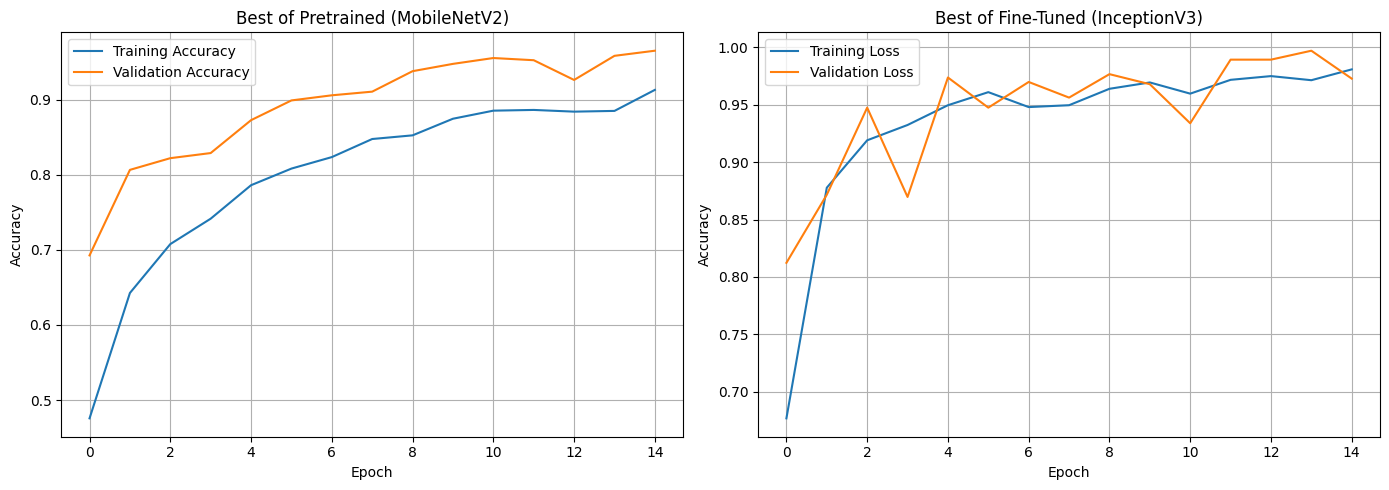

In [29]:
import pandas as pd

frozen_metrics_df = pd.DataFrame(history_frozen['MobileNetV2'].history)
fine_tuned_metrics_df = pd.DataFrame(history_tuned['InceptionV3'].history)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axs[0].plot(frozen_metrics_df['accuracy'], label='Training Accuracy')
axs[0].plot(frozen_metrics_df['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Best of Pretrained (MobileNetV2)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(fine_tuned_metrics_df['accuracy'], label='Training Loss')
axs[1].plot(fine_tuned_metrics_df['val_accuracy'], label='Validation Loss')
axs[1].set_title('Best of Fine-Tuned (InceptionV3)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### 3. Plot Test Accuracies for Pretrained and Fine-Tuned Models

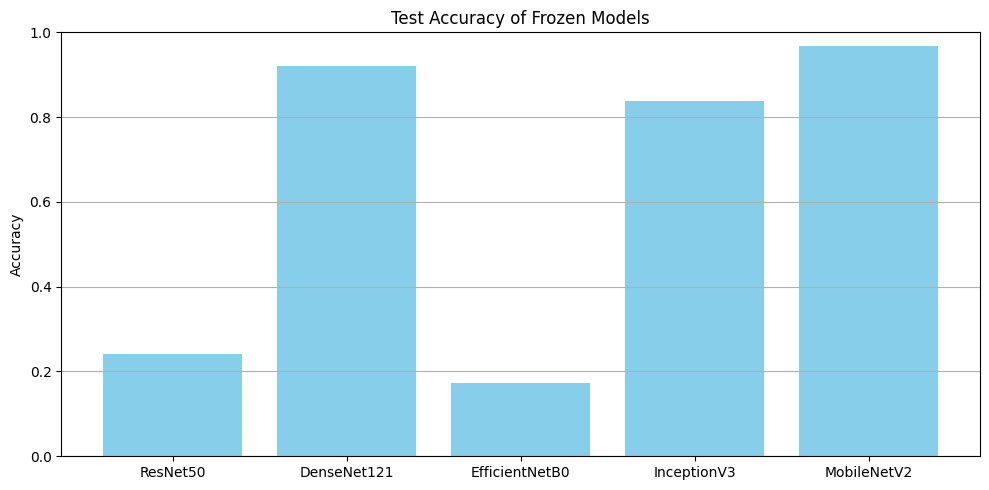

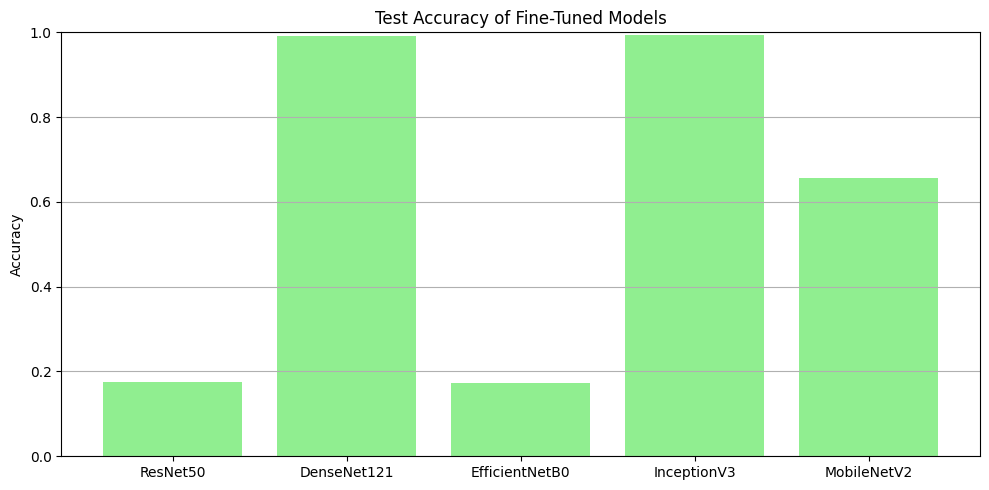

In [30]:
# Plot 1: Frozen Models
plt.figure(figsize=(10, 5))
plt.bar(frozen_accuracies.keys(), frozen_accuracies.values(), color='skyblue')
plt.title('Test Accuracy of Frozen Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Fine-Tuned Models
plt.figure(figsize=(10, 5))
plt.bar(fine_tuned_accuracies.keys(), fine_tuned_accuracies.values(), color='lightgreen')
plt.title('Test Accuracy of Fine-Tuned Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 4. Save the Best Pretrained and Fine-Tuned Models

In [32]:
frozen_models['MobileNetV2'].save('pretrained_MobileNetV2_classifier.h5')
fine_tuned_models['InceptionV3'].save('fine_tuned_InceptionV3_classifier.h5')

### 5. Download the Best Pretrained and Fine-Tuned Models

In [34]:
from IPython.display import FileLink

FileLink('pretrained_MobileNetV2_classifier.h5')

/kaggle/working/pretrained_MobileNetV2_classifier.h5

In [35]:
FileLink('fine_tuned_InceptionV3_classifier.h5')

/kaggle/working/fine_tuned_InceptionV3_classifier.h5